# Spacy test

## Import neccesary libraries

In [1]:
import spacy
from spacy import displacy
from spacy.matcher import Matcher
import pandas as pd
pd.set_option('display.max_colwidth', None)
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity
from gensim.models import KeyedVectors
import re
import numpy as np
from pprint import pprint
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from sklearn.decomposition import PCA
import seaborn as sns
from wikipedia2vec import Wikipedia2Vec

In [2]:
# use pre-trained corpus to help tokenise words
nlp = spacy.load('en_core_web_sm')

## Terms explained
Document -> a bunch of texts <br>
Corpus -> a bunch of documents <br>
Vectors -> a mathematically convenience representation of a document (a bunch of textx) <br>
Models -> an algorithm for transforming vectors from one representation to another <br>

# load data

In [3]:
netflixDf = pd.read_csv('df_with_5cols.csv', usecols=['title','type','description','genres','originals'])

In [8]:
# movie = pd.read_csv('nMovieRg.csv', usecols=['title','description'])
# tvshow = pd.read_csv('nTvshowRg.csv', usecols=['title','description'])

In [10]:
# netflix_df = movie.append(tvshow, ignore_index=True)

### Each description is a "doc". The collection of these "docs" is the "corpus".

In [4]:
corpus = netflixDf.description.values.tolist() #list of docs

In [5]:
def tokenise(doc):
    """Use spacy as the nlp object to tokenise each doc"""
    return [token.text for token in nlp(doc)]

In [6]:
corpus_with_tkdocs = [tokenise(doc) for doc in corpus]

In [7]:
# mapping out the title and each description. so later on i can search 
title_text = dict(zip(netflixDf['title'].str.lower().tolist(), corpus_with_tkdocs))
# lower the title (easy for search)

### Use pre-trained google news model to train my w2v model
It might take a few seconds to train

In [8]:
# path = "GoogleNews-vectors-negative300.bin"
# w2v = KeyedVectors.load_word2vec_format(path, binary=True)

In [2]:
# Use wiki2vec
MODEL_FILE = "enwiki_20180420_300d.pkl.bz2"
w2v = Wikipedia2Vec.load(MODEL_FILE)

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/contextlib.py:113: UserWarning: mmap_mode "c" is not compatible with compressed file enwiki_20180420_300d.pkl.bz2. "c" flag will be ignored.
  return next(self.gen)


ValueError: mmap length is greater than file size

In [15]:
# this is one way to get each title's vector representation
# more investagtion is needed later.

def get_vectors(first_map, second_map):
    first_vec  = dict()
    for title, description in first_map.items():
        temp = list()
        for element in description: #element = tokenised words
            try:
                temp.append(second_map[element]) #secondmap is w2v model which should have a responding word vecotr for the tokenise word
            except KeyError:
                pass
        first_vec[title] = np.mean(temp, axis=0)
    
    return first_vec

In [10]:
def get_most_similar(lookup_id, title_vec):

    sim = list()
    lookup_map = title_vec
    subject_map = title_vec 
        
    for uid, vec in lookup_map.items():
        thisSim = cosine_similarity(vec.reshape(1, -1), subject_map[lookup_id].reshape(1, -1))
        sim.append((uid, thisSim[0][0]))

    return sorted(sim, key=lambda x: x[1], reverse=True)

In [16]:
title_vec = get_vectors(title_text, w2v)

alert
alert
alert
alert
alert
alert
alert
alert
alert
alert
alert
alert
alert
alert
alert
alert
alert
alert
alert
alert
alert
alert
alert
alert
alert
alert
alert
alert
alert
alert
alert
alert
alert
alert
alert
alert
alert
alert
alert
alert
alert
alert
alert
alert
alert
alert
alert
alert
alert
alert
alert
alert
alert
alert
alert
alert
alert
alert
alert
alert
alert
alert
alert
alert
alert
alert
alert
alert
alert
alert
alert
alert
alert
alert
alert
alert
alert
alert
alert
alert
alert
alert
alert
alert
alert
alert
alert
alert
alert
alert
alert
alert
alert
alert
alert
alert
alert
alert
alert
alert
alert
alert
alert
alert
alert
alert
alert
alert
alert
alert
alert
alert
alert
alert
alert
alert
alert
alert
alert
alert
alert
alert
alert
alert
alert
alert
alert
alert
alert
alert
alert
alert
alert
alert
alert
alert
alert
alert
alert
alert
alert
alert
alert
alert
alert
alert
alert
alert
alert
alert
alert
alert
alert
alert
alert
alert
alert
alert
alert
alert
alert
alert
alert
alert
alert
alert
aler

In [27]:
d = {}
for t in netflixDf.title.str.lower().tolist():
    if t not in d.keys():
        d[t] = 1
    else:
        d[t] += 1

In [30]:
for k, v in d.items():
    if v != 1:
        print(k, v)

taxi driver 4
drive 4
cloudy with a chance of meatballs 4
the gift 4
the queen 4
hush 4
aquarius 4
veronica 4
she's gotta have it 4
ittefaq 4
one day 4
bleach 4
furie 4
pink 4
love 4
andaz apna apna 4
a futile and stupid gesture 4
the burial of kojo 4
the secret 4
the saint 4
shadow 4
the laundromat 4
game over 4
the oath 4
sergio 4
fullmetal alchemist 4
see you yesterday 4
don 4
the outsider 9
aftermath 4
aurora 4
the student 4
hostages 4
the silence 4
death note 4
the international 4
one of us 4
a second chance 4
skins 4
my babysitter's a vampire 4
the forest 9
lavender 4
paradox 4
manhunt 2
the chase 4
we are family 4
lucid dream 4
santa claws 4
fifty 4
stray bullet 4
all about love 4
the end 4
limitless 4
justice 4
zoo 4
maniac 4
charmed 4
erased 2
the code 4
inspector gadget 4
the good cop 4
danger mouse 4


In [25]:
len(list(title_vec.keys()))

5577

In [19]:
for title in netflixDf.title.str.lower().tolist():
    if title not in list(title_vec.keys()):
        print(title)

In [12]:
get_most_similar('house of cards', title_vec)[1:11]

[('bloodline', 0.9467709),
 ('reign', 0.9466064),
 ('broadchurch', 0.9440308),
 ('peaky blinders', 0.9435389),
 ('the end of the f***ing world', 0.9429343),
 ('hostages', 0.9425726),
 ('collateral', 0.9425075),
 ('breaking bad', 0.94222677),
 ('sherlock', 0.94206876),
 ('orange is the new black', 0.9417874)]

In [ ]:
def sim_title_description(title, dataset):
    """Return the title description"""
    filt = dataset['title'].str.lower() == title
    return dataset.loc[filt]['description'].values.tolist()[0]

In [ ]:
def dscp_comparison(org, dataset, vec):
    
    org = org.lower()
    org_dscp = dataset.loc[dataset['title'].str.lower() == org]['description'].values.tolist()[0]
    print(f"The input title name is '{org}'\n")
    print(org_dscp, '\n')
    sim = get_most_similar(org, vec)[1:11]
    
    for i in range(len(sim)):
        title = sim[i][0]
        print(f"The most similiar No.{i+1} is '{title}'\n")
        print(sim_title_description(title, dataset),'\n')

In [ ]:
title = "Star Wars: The Rise of Skywalker (Episode IX)".lower()
dscp_comparison(title, data6k, title_vec6k)

In [ ]:
title = ("Star Wars: The Rise of Skywalker (Episode IX)").lower()
sim = get_most_similar(title, title_vec6k)[1:11]
pprint(sim)

# Display scatterplot

In [28]:
def display_pca_scatterplot(titles, vec):
    
    title_vectors = np.array([vec[title] for title in titles])
    twodim = PCA().fit_transform(title_vectors)[:,:2]
    plt.figure(figsize=(12,12))
    plt.scatter(twodim[:,0], twodim[:,1], edgecolors='k', c='grey')
#     for title, (x,y) in zip(titles, twodim):
#         plt.text(x+0.05, y+0.05, title)
    plt.show()

In [31]:
# titles = np.random.choice(netflix_df['title'].values, size = 1000).tolist()
titles = netflix_df['title'].values.tolist()
titles = [title.lower() for title in titles]

In [132]:
netflix_df[netflix_df.duplicated()]

,title,description
650,The Burial of Kojo,A man is trapped in a mine shaft by his vengeful brother while his daughter embarks on a magical journey to rescue him.The Burial of Kojo featuring Ama K. Abebrese and Joe Addo is streaming with subscription on Netflix. It's a drama and mystery movie with a very high Rotten Tomatoes (critics) score of 100% and an average IMDb audience rating of 6.4 (505 votes).
653,A Futile and Stupid Gesture,"The National Lampoon name became globally recognized after the monumental success of Animal House—but before the glory days, it was a scrappy yet divinely subversive magazine and radio show that introduced the world to comedic geniuses like Bill Murray, Chevy Chase, John Belushi, and Gilda Radner. The driving force behind National Lampoon was Doug Kenney (Will Forte), and his truly wild and crazy story unfolds in A Futile and Stupid Gesture from Harvard to Hollywood to Caddyshack and beyond.A Futile and Stupid Gesture featuring Will Forte and Domhnall Gleeson is streaming with subscription on Netflix. It's a biography and comedy movie with an average Rotten Tomatoes (critics) score of 61% and a better than average IMDb audience rating of 6.8 (12,621 votes)."
663,Andaz Apna Apna,"Two slackers competing for the affections of an heiress inadvertently become her protectors from an evil criminal.Andaz Apna Apna featuring Aamir Khan and Salman Khan is streaming with subscription on Netflix, streaming with subscription on Prime Video, available for rent or purchase on iTunes, and 2 others. It's an action & adventure and comedy movie with a high IMDb audience rating of 8.2 (47,824 votes)."


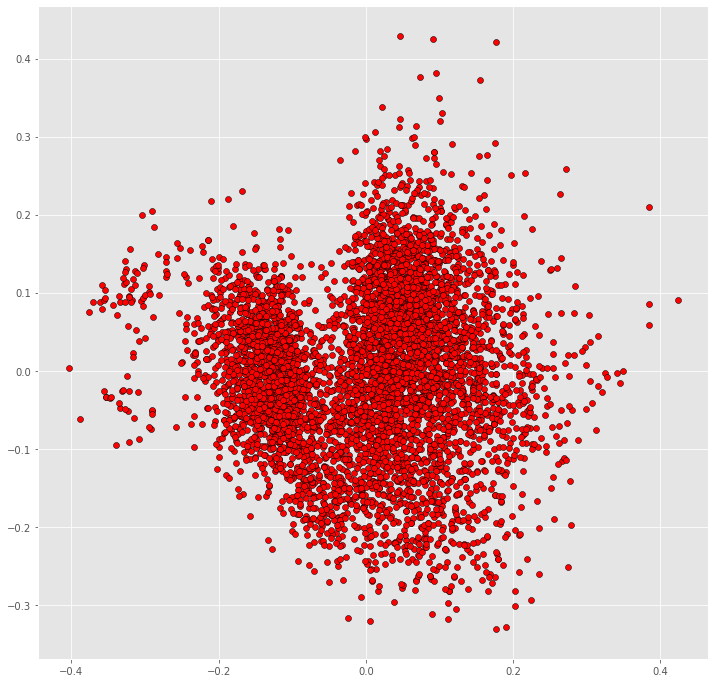

In [32]:
display_pca_scatterplot(titles, title_vec)

#  Try T-SNE

In [14]:
netflixDf.shape

(5769, 5)

In [13]:
len(list(title_vec.keys()))

5577

In [48]:
values = np.array(list(title_vec.values()))
labels = list(title_vec.keys())

In [49]:
tsne = TSNE(n_components=2, random_state=1)
tsne_values = tsne.fit_transform(values)

In [51]:
tsne_data = np.vstack((tsne_values.T, labels)).T

In [55]:
tsne_df = pd.DataFrame(data=tsne_data, columns=['Dim1','Dim2','Titles'])

In [127]:
tsne_df.shape

(5585, 3)

In [62]:
test = tsne_df.head(15)

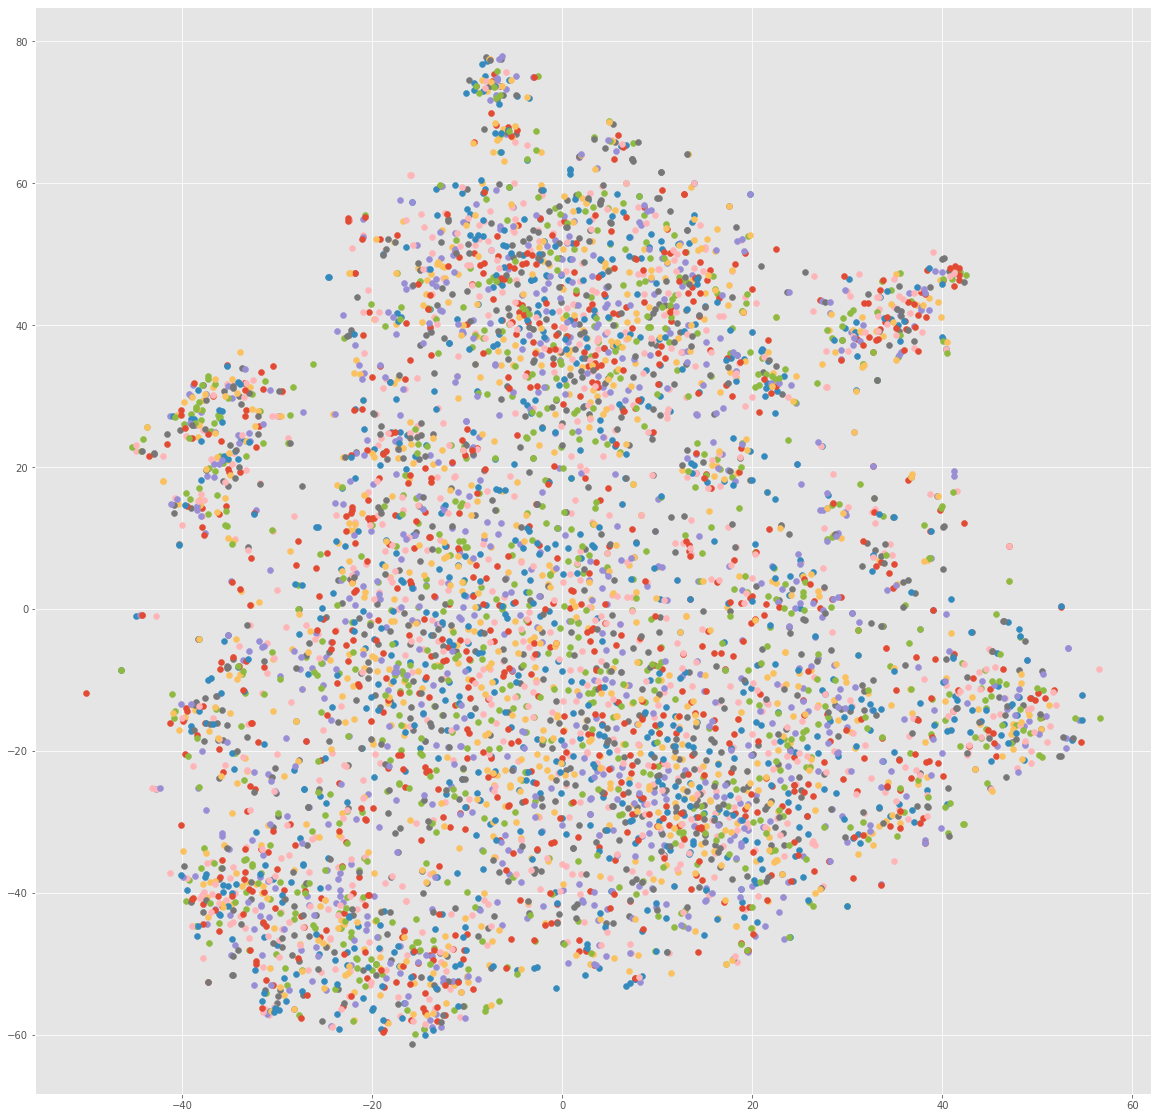

In [69]:
x, y = [], []
for item in tsne_values:
    x.append(item[0])
    y.append(item[1])
    
plt.figure(figsize=(20, 20))
for ix, _ in enumerate(x):
    plt.scatter(x[ix], y[ix])
plt.show()

# K-means

In [76]:
from sklearn.cluster import KMeans

In [81]:
kmean_df = tsne_df.drop('Titles',axis=1)

In [114]:
kmeans = KMeans(n_clusters=10)
kmeans.fit(kmean_df)

KMeans(n_clusters=10)

In [115]:
labels = kmeans.predict(kmean_df)
centroids = kmeans.cluster_centers_

In [123]:
kmean_df.columns

Index(['Dim1', 'Dim2'], dtype='object')

In [117]:
set(labels)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}

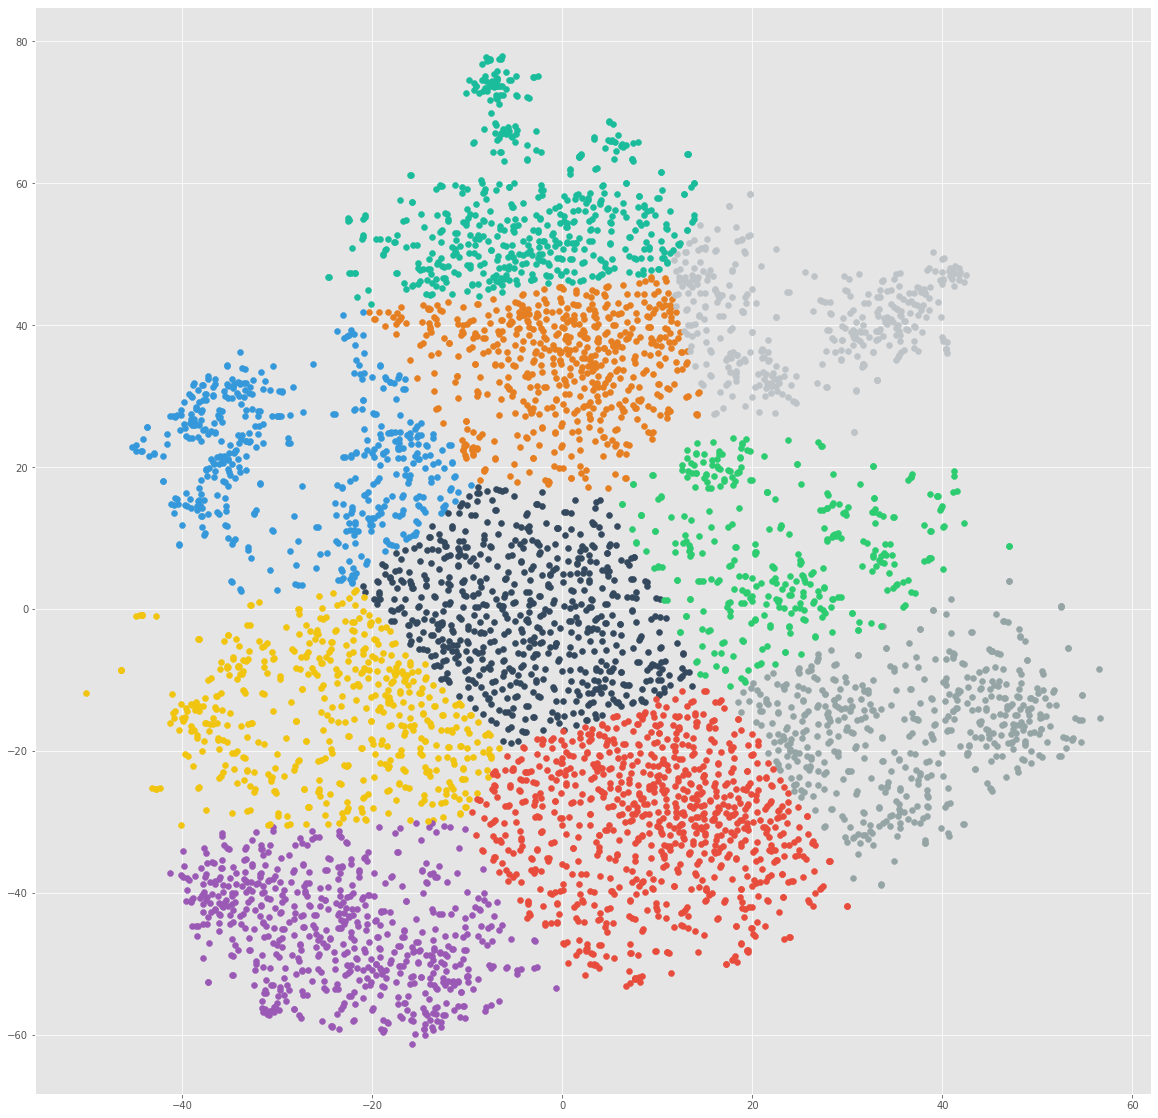

In [118]:
colors = ['#1abc9c','#f1c40f','#2ecc71','#e67e22','#3498db','#e74c3c','#9b59b6','#bdc3c7','#34495e','#95a5a6']
color_dict = dict()
for ix in range(10):
    color_dict[str(ix)] = colors[ix]
    
color = list()
for label in labels:
    color.append(color_dict[str(label)])

x, y = [], []
for item in tsne_values:
    x.append(item[0])
    y.append(item[1])
    
plt.figure(figsize=(20, 20))
for ix, _ in enumerate(x):
    plt.scatter(x[ix], y[ix], color=color[ix])

plt.show()

In [105]:
kmeans.inertia_

2854632.374099743

In [106]:
len(labels)

5585

In [108]:
wcss = []

for i in range(1,30):
    kmeans = KMeans(i)
    kmeans.fit(kmean_df)
    wcss_iter = kmeans.inertia_
    wcss.append(wcss_iter)

In [113]:
for i in range(1,30):
    print(wcss[i]-wcss[i-1])

-4533799.784832978
-1407053.0986978873
-837698.9009866577
-330621.9344925985
-280141.64257433824
-241530.0383723185
-165149.5580895011
-103285.0838306616
-93038.02655838907
-82216.93037489417
-57489.49643496983
-48421.437033688766
-43733.59201619215
-47979.54390547046
-34935.85116959852
-35179.847289289406
-31952.022348311206
-24953.477027618384
-18509.597836396657
-23853.74630864564
-15626.629368622089
-14568.848637147574
-12538.79343821446
-14977.072193585103
-9268.885588090925
-9772.314465664094
-12421.576665436383
-9565.029204225924


IndexError: list index out of range

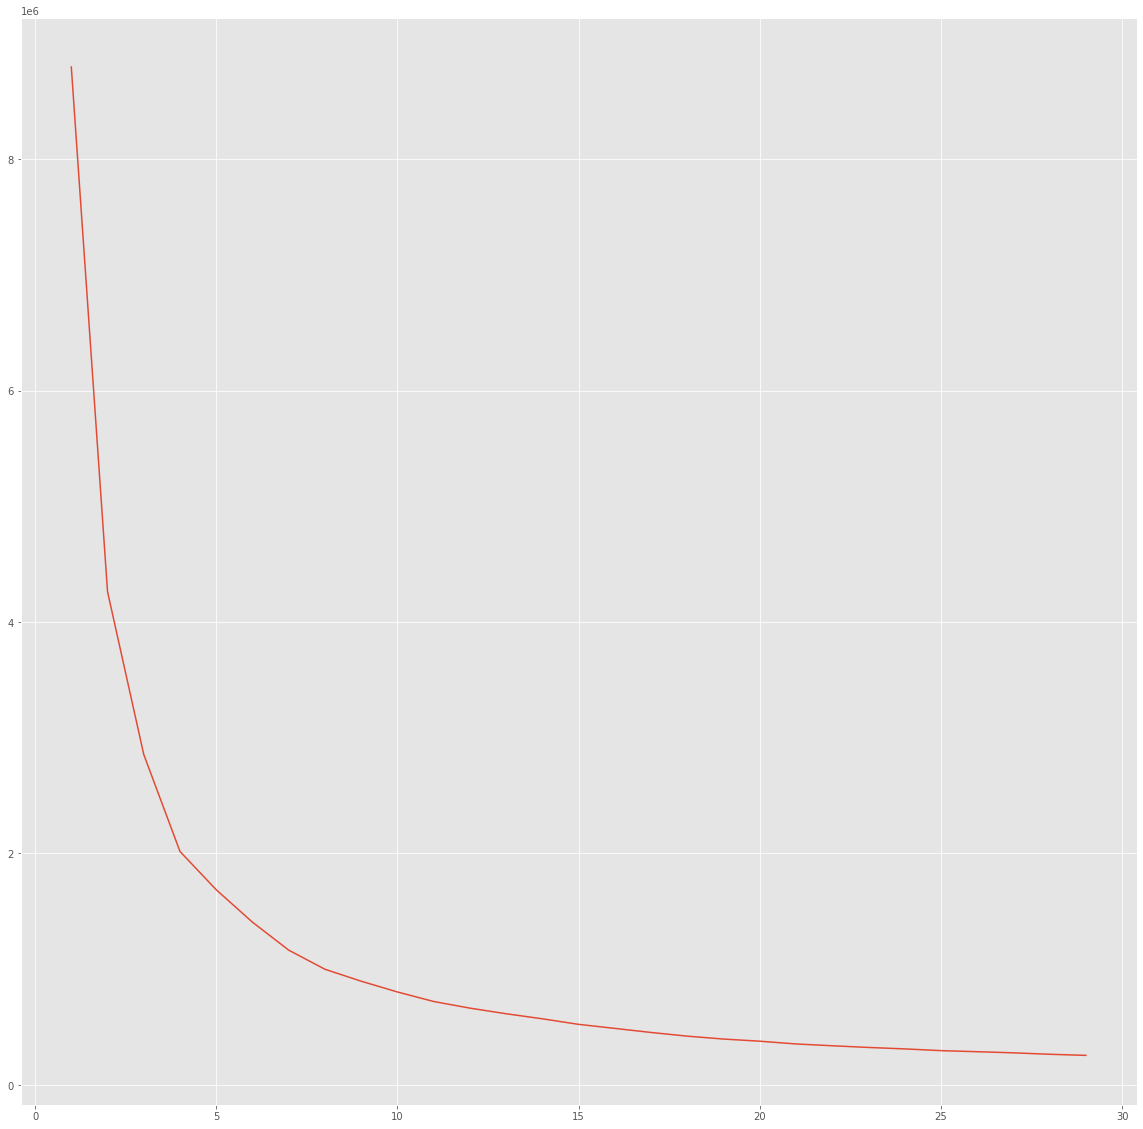

In [111]:
number_clusters = range(1,30)
plt.figure(figsize=(20,20))
plt.plot(number_clusters, wcss)
plt.show()

# Clean the data 

Now that the clustering seems fine. I need to clean the 5k dataset to make sure the information is in place.

In [124]:
cluster_df = pd.DataFrame()
cluster_df['title'] = tsne_df.Titles
cluster_df['label'] = labels

In [125]:
filt = cluster_df['label'] == 0
cluster_df.loc[filt]

,title,label
129,the gift,0
381,she's gotta have it,0
744,shadow,0
902,the oath,0
2711,fifty,0
...,...,...
5580,bal ganesh,0
5581,the ultimatum,0
5582,titipo titipo,0
5583,the underwear,0


In [126]:
netflix_df

,title,description
0,Inception,"Cobb, a skilled thief who commits corporate espionage by infiltrating the subconscious of his targets is offered a chance to regain his old life as payment for a task considered to be impossible: ""inception"", the implantation of another person's idea into a target's subconscious.Inception featuring Leonardo DiCaprio and Joseph Gordon-Levitt is streaming with subscription on Netflix, streaming via tv everywhere with TBS, streaming via tv everywhere with TNT, and 4 others. It's an action & adventure and mystery movie with a high Rotten Tomatoes (critics) score of 87% and a high IMDb audience rating of 8.8 (1,977,032 votes)."
1,Back to the Future,"Eighties teenager Marty McFly is accidentally sent back in time to 1955, inadvertently disrupting his parents' first meeting and attracting his mother's romantic interest. Marty must repair the damage to history by rekindling his parents' romance and - with the help of his eccentric inventor friend Doc Brown - return to 1985.Back to the Future featuring Michael J. Fox and Christopher Lloyd is streaming with subscription on Netflix, streaming on Showtime, streaming with subscription on fuboTV, and 6 others. It's an action & adventure and comedy movie with a very high Rotten Tomatoes (critics) score of 96% and a high IMDb audience rating of 8.5 (1,011,582 votes)."
2,The Matrix,"Set in the 22nd century, The Matrix tells the story of a computer hacker who joins a group of underground insurgents fighting the vast and powerful computers who now rule the earth.The Matrix featuring Keanu Reeves and Laurence Fishburne is streaming with subscription on Netflix, available for rent or purchase on iTunes, available for rent or purchase on Prime Video, and 2 others. It's an Action & Adventure and Science Fiction movie with a high Rotten Tomatoes (critics) score of 88% and a high IMDb audience rating of 8.7 (1,616,735 votes)."
3,"The Good, the Bad and the Ugly","While the Civil War rages between the Union and the Confederacy, three men – a quiet loner, a ruthless hit man and a Mexican bandit – comb the American Southwest in search of a strongbox containing $200,000 in stolen gold.The Good, the Bad and the Ugly featuring Clint Eastwood and Eli Wallach is streaming with subscription on Netflix, streaming with subscription on Prime Video, available for rent or purchase on iTunes, and 5 others. It has a very high Rotten Tomatoes (critics) score of 97% and a high IMDb audience rating of 8.8 (665,805 votes)."
4,Avengers: Infinity War,"As the Avengers and their allies have continued to protect the world from threats too large for any one hero to handle, a new danger has emerged from the cosmic shadows: Thanos. A despot of intergalactic infamy, his goal is to collect all six Infinity Stones, artifacts of unimaginable power, and use them to inflict his twisted will on all of reality. Everything the Avengers have fought for has led up to this moment - the fate of Earth and existence itself has never been more uncertain.Avengers: Infinity War featuring Robert Downey Jr. and Chris Hemsworth is streaming with subscription on Netflix, available for rent or purchase on iTunes, available for rent or purchase on Google Play, and 4 others. It's an action & adventure and fantasy movie with a high Rotten Tomatoes (critics) score of 85% and a high IMDb audience rating of 8.4 (782,188 votes)."
...,...,...
5644,Bal Ganesh,Bal Ganesh has one or more episodes streaming with subscription on Netflix. It's an animation show with 13 episodes over 1 season. Bal Ganesh is still airing with no announced date for the next episode or season.
5645,The Ultimatum,"The Ultimatum has one or more episodes streaming with subscription on Netflix, and free on Crunchyroll. It has 30 episodes over 1 season. The Ultimatum is still airing with no announced date for the next episode or season."
5646,Titipo Titipo,"Titipo Titipo has one or more episodes streaming with subscription on Netflix, streaming with subscrip